In [1]:
get_ipython().system('pip install db-dtypes')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

CONFIGURE THE BIGQUERY SETTINGS

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data` 
"""
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,90,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>


In [6]:
# Getting the no of columns to understand and choose the required ones
data.shape

(16833, 25)

inorder to know which columns are responsible or making a variation in predicting the unemployment claims,we need to find 
the correlation between them and drop the unnecessary colummns from the data frame.

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_6566/3188068582.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


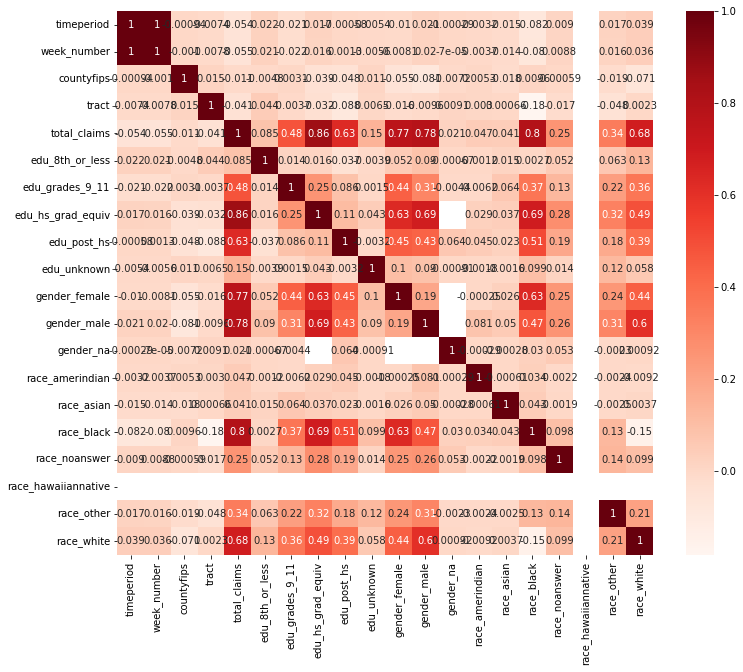

In [7]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [8]:
data['total_claims']
print("min",data['total_claims'].min(),"max",data['total_claims'].max())
print(data.columns)

min 10 max 170
Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white'],
      dtype='object')


In [9]:
#Correlation with output variable
cor_target = abs(cor["total_claims"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

total_claims         1.000000
edu_hs_grad_equiv    0.863481
edu_post_hs          0.629552
gender_female        0.767174
gender_male          0.783093
race_black           0.795195
race_white           0.683659
Name: total_claims, dtype: float64


In [10]:
print(data.columns)
data=data[["uu_id","week_number","total_claims","edu_hs_grad_equiv","edu_post_hs","gender_female","gender_male","race_black","race_white"]]
data.columns
test=data

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white'],
      dtype='object')


In [11]:
test=test.fillna(0,axis=0)
test["week_number"]= test["week_number"].astype("int")
test

,uu_id,week_number,total_claims,edu_hs_grad_equiv,edu_post_hs,gender_female,gender_male,race_black,race_white
0,f013068de98db1470bd986137a0c6d23,16,22,14,0,0,0,11,0
1,21957d5517323845818d87623589e1ba,12,111,108,0,76,35,0,0
2,6a5609f385912113b6f1014b958ed748,13,39,0,0,0,0,39,0
3,46b2882ec4c373527ec33f7bd4f1388d,29,14,0,0,0,0,10,0
4,37495d17e82f7df326bfc2c4c090f7b7,15,155,69,83,90,65,135,0
...,...,...,...,...,...,...,...,...,...
16828,f35320206f3dd1ffc411e4ac127caf92,25,21,0,12,0,0,0,14
16829,f35320206f3dd1ffc411e4ac127caf92,35,22,13,0,0,0,0,0
16830,f35320206f3dd1ffc411e4ac127caf92,35,22,13,0,0,0,0,0
16831,bbcb018f0e5e49e13636f6e78ce9f60f,13,53,48,0,0,0,0,0


In [12]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X_train=test.drop(["uu_id"],axis=1)
X_train=X_train.loc[X_train["week_number"]<=33]
y=X_train["total_claims"]
X_test=test.drop(["uu_id"],axis=1)
X_test = X_test.loc[X_test["week_number"]==34]

In [13]:
model.fit(X_train,y)

LinearRegression()

In [14]:
X_test = X_test.loc[X_test["week_number"]==34]
X_test.head(10)
data.iloc[X_test.index(),'uu_id']

TypeError: 'Int64Index' object is not callable

In [15]:
X_test = X_test.loc[X_test["week_number"]==34]
X_test.head(10)
data.iloc[X_test.index,'uu_id']

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [16]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X_train=test.drop(["uu_id"],axis=1)
X_train=X_train.loc[X_train["week_number"]<=33]
y=X_train["total_claims"]
X_test=test.drop(["uu_id"],axis=1)
X_test = X_test.loc[X_test["week_number"]==34]
temp=test.loc[test["week_number"]==34]

In [17]:
model.fit(X_train,y)

LinearRegression()

In [18]:
X_test = X_test.loc[X_test["week_number"]==34]
X_test.head(10)
temp

,uu_id,week_number,total_claims,edu_hs_grad_equiv,edu_post_hs,gender_female,gender_male,race_black,race_white
5,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0
6,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0
31,06e492b4f29d153af26c659d1f7da2a1,34,23,15,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13,0,0,0,0,0,0
16740,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14,0,0,0,0,0,0


In [19]:
a=pd.Dataframe(data=temp)
a

AttributeError: module 'pandas' has no attribute 'Dataframe'

In [20]:
a=pd.DataFrame(data=temp)
a

,uu_id,week_number,total_claims,edu_hs_grad_equiv,edu_post_hs,gender_female,gender_male,race_black,race_white
5,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0
6,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0
31,06e492b4f29d153af26c659d1f7da2a1,34,23,15,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13,0,0,0,0,0,0
16740,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14,0,0,0,0,0,0


In [21]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a

NameError: name 'y_pred' is not defined

In [22]:
y_pred = model.predict(X_test)
y_pred

array([24., 24., 19., 19., 23., 23., 17., 17., 14., 14., 15., 15., 28.,
       28., 35., 35., 26., 26., 12., 12., 42., 42., 35., 35., 11., 11.,
       26., 26., 18., 18., 19., 19., 17., 17., 23., 23., 13., 13., 18.,
       18., 19., 19., 14., 14., 11., 11., 12., 12., 16., 16., 18., 18.,
       16., 16., 11., 11., 17., 17., 14., 14., 22., 22., 10., 10., 28.,
       28., 34., 34., 58., 58., 13., 13., 27., 27., 32., 32., 21., 21.,
       28., 28., 19., 19., 15., 15., 21., 21., 23., 23., 10., 10., 12.,
       12., 13., 13., 21., 21., 41., 41., 23., 23., 11., 11., 67., 67.,
       38., 38., 10., 10., 19., 19., 30., 30., 16., 16., 18., 18., 31.,
       31., 19., 19., 28., 28., 19., 19., 12., 12., 20., 20., 18., 18.,
       12., 12., 14., 14., 25., 25., 10., 10., 17., 17., 21., 21., 13.,
       13., 25., 25., 12., 12., 16., 16., 16., 16., 14., 14., 18., 18.,
       13., 13., 16., 16., 18., 18., 10., 10., 10., 10., 15., 15., 13.,
       13., 14., 14., 11., 11., 20., 20., 16., 16., 42., 42., 20

In [23]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a

,uu_id,week_number,total_claims,edu_hs_grad_equiv,edu_post_hs,gender_female,gender_male,race_black,race_white,count
5,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0,24.0
6,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0,24.0
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0,19.0
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0,19.0
31,06e492b4f29d153af26c659d1f7da2a1,34,23,15,0,0,0,0,23,23.0
...,...,...,...,...,...,...,...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13,0,0,0,0,0,0,13.0
16740,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12,12.0
16743,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12,12.0
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14,0,0,0,0,0,0,14.0


In [24]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a[count].astype('int')
a

NameError: name 'count' is not defined

In [25]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a

,uu_id,week_number,total_claims,edu_hs_grad_equiv,edu_post_hs,gender_female,gender_male,race_black,race_white,count
5,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0,23
6,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0,19
31,06e492b4f29d153af26c659d1f7da2a1,34,23,15,0,0,0,0,23,22
...,...,...,...,...,...,...,...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13,0,0,0,0,0,0,13
16740,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14,0,0,0,0,0,0,14


In [26]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
columns=['uu

SyntaxError: EOL while scanning string literal (3313652958.py, line 4)

In [27]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
columns=['uu_id','week','count']
a=a.loc[:,columns]
a

KeyError: "['week'] not in index"

In [28]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
columns=['uu_id','week','count']
a=a.iloc[:,columns]
a

IndexError: .iloc requires numeric indexers, got ['uu_id' 'week' 'count']

In [29]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
columns=['uu_id','week','count']
a=a[[columns]]
a

KeyError: "None of [Index([('uu_id', 'week', 'count')], dtype='object')] are in the [columns]"

In [30]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
columns=['uu_id','week','count']
a=a[['uu_id','week','count']]
a

KeyError: "['week'] not in index"

In [31]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
columns=['uu_id','week','count']
a=a[['uu_id','week_number','count']]
a

,uu_id,week_number,count
5,25a57fe39e03c632125308737a7d3769,34,23
6,25a57fe39e03c632125308737a7d3769,34,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
31,06e492b4f29d153af26c659d1f7da2a1,34,22
...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13
16740,447d5984bb8a8179bff002ccd1bba162,34,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14


In [32]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a=a[['uu_id','week_number','count']]
a['week_number'].replace('week')
a

,uu_id,week_number,count
5,25a57fe39e03c632125308737a7d3769,34,23
6,25a57fe39e03c632125308737a7d3769,34,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
31,06e492b4f29d153af26c659d1f7da2a1,34,22
...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13
16740,447d5984bb8a8179bff002ccd1bba162,34,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14


In [33]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a=a[['uu_id','week_number','count']]
a.rename('week_number':'week')
a

SyntaxError: invalid syntax (2930344465.py, line 5)

In [34]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a=a[['uu_id','week_number','count']]
a.rename(columns={'week_number':'week'})
a

,uu_id,week_number,count
5,25a57fe39e03c632125308737a7d3769,34,23
6,25a57fe39e03c632125308737a7d3769,34,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
31,06e492b4f29d153af26c659d1f7da2a1,34,22
...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13
16740,447d5984bb8a8179bff002ccd1bba162,34,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14


In [35]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a=a[['uu_id','week_number','count']]
a=a.rename(columns={'week_number':'week'})
a

,uu_id,week,count
5,25a57fe39e03c632125308737a7d3769,34,23
6,25a57fe39e03c632125308737a7d3769,34,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
31,06e492b4f29d153af26c659d1f7da2a1,34,22
...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13
16740,447d5984bb8a8179bff002ccd1bba162,34,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14


In [36]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a=a[['uu_id','week_number','count']]
a=a.rename(columns={'week_number':'week'})
a.to_string(index=False)

'                           uu_id  week  count\n25a57fe39e03c632125308737a7d3769    34     23\n25a57fe39e03c632125308737a7d3769    34     23\n5e9480dba0f8de932f4d9fb55fa6b8b1    34     19\n5e9480dba0f8de932f4d9fb55fa6b8b1    34     19\n06e492b4f29d153af26c659d1f7da2a1    34     22\n06e492b4f29d153af26c659d1f7da2a1    34     22\n98e63567a2f4907c9cb2637247651530    34     17\n98e63567a2f4907c9cb2637247651530    34     17\n592a852d462dffe18312976a3da5b7d8    34     14\n592a852d462dffe18312976a3da5b7d8    34     14\na21252ae119bf94fb9343a9d279b1f09    34     15\na21252ae119bf94fb9343a9d279b1f09    34     15\n8f782a6153268c6031e31784e2d4eae2    34     27\n8f782a6153268c6031e31784e2d4eae2    34     27\n5c04f20bd2f8552aa7ac210dc01292fb    34     34\n5c04f20bd2f8552aa7ac210dc01292fb    34     34\nd199aebcfab8dd5f47f9a2d645e5e25d    34     25\nd199aebcfab8dd5f47f9a2d645e5e25d    34     25\n07306ce64b3496b7955efaaf7509d73c    34     12\n07306ce64b3496b7955efaaf7509d73c    34     12\n44585653fcc9

In [37]:
a.to_csv("submission.csv",index=False)
a

,uu_id,week,count
5,25a57fe39e03c632125308737a7d3769,34,23
6,25a57fe39e03c632125308737a7d3769,34,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19
31,06e492b4f29d153af26c659d1f7da2a1,34,22
...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13
16740,447d5984bb8a8179bff002ccd1bba162,34,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14


In [38]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a=a[['uu_id','week_number','count']]
a['week_number']=a['week_number+1']
a=a.rename(columns={'week_number':'week'})
a.to_string(index=False)

KeyError: 'week_number+1'

In [39]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a=a[['uu_id','week_number','count']]
a['week_number']=a['week_number']+1
a=a.rename(columns={'week_number':'week'})
a.to_string(index=False)

'                           uu_id  week  count\n25a57fe39e03c632125308737a7d3769    35     23\n25a57fe39e03c632125308737a7d3769    35     23\n5e9480dba0f8de932f4d9fb55fa6b8b1    35     19\n5e9480dba0f8de932f4d9fb55fa6b8b1    35     19\n06e492b4f29d153af26c659d1f7da2a1    35     22\n06e492b4f29d153af26c659d1f7da2a1    35     22\n98e63567a2f4907c9cb2637247651530    35     17\n98e63567a2f4907c9cb2637247651530    35     17\n592a852d462dffe18312976a3da5b7d8    35     14\n592a852d462dffe18312976a3da5b7d8    35     14\na21252ae119bf94fb9343a9d279b1f09    35     15\na21252ae119bf94fb9343a9d279b1f09    35     15\n8f782a6153268c6031e31784e2d4eae2    35     27\n8f782a6153268c6031e31784e2d4eae2    35     27\n5c04f20bd2f8552aa7ac210dc01292fb    35     34\n5c04f20bd2f8552aa7ac210dc01292fb    35     34\nd199aebcfab8dd5f47f9a2d645e5e25d    35     25\nd199aebcfab8dd5f47f9a2d645e5e25d    35     25\n07306ce64b3496b7955efaaf7509d73c    35     12\n07306ce64b3496b7955efaaf7509d73c    35     12\n44585653fcc9

In [40]:
a.to_csv("submission.csv",index=False)
a

,uu_id,week,count
5,25a57fe39e03c632125308737a7d3769,35,23
6,25a57fe39e03c632125308737a7d3769,35,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,35,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,35,19
31,06e492b4f29d153af26c659d1f7da2a1,35,22
...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,35,13
16740,447d5984bb8a8179bff002ccd1bba162,35,12
16743,447d5984bb8a8179bff002ccd1bba162,35,12
16809,06c78e49b4daedfeb808c42e58fb25e4,35,14


In [41]:
a.to_csv("submission.csv",index=False)
a

,uu_id,week,count
5,25a57fe39e03c632125308737a7d3769,35,23
6,25a57fe39e03c632125308737a7d3769,35,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,35,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,35,19
31,06e492b4f29d153af26c659d1f7da2a1,35,22
...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,35,13
16740,447d5984bb8a8179bff002ccd1bba162,35,12
16743,447d5984bb8a8179bff002ccd1bba162,35,12
16809,06c78e49b4daedfeb808c42e58fb25e4,35,14


In [42]:
a.to_csv("submission1.csv",index=False)
a

,uu_id,week,count
5,25a57fe39e03c632125308737a7d3769,35,23
6,25a57fe39e03c632125308737a7d3769,35,23
23,5e9480dba0f8de932f4d9fb55fa6b8b1,35,19
26,5e9480dba0f8de932f4d9fb55fa6b8b1,35,19
31,06e492b4f29d153af26c659d1f7da2a1,35,22
...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,35,13
16740,447d5984bb8a8179bff002ccd1bba162,35,12
16743,447d5984bb8a8179bff002ccd1bba162,35,12
16809,06c78e49b4daedfeb808c42e58fb25e4,35,14
